In [1]:
data = open('names.txt','r').read().splitlines()
data

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn',
 'abigail',
 'emily',
 'elizabeth',
 'mila',
 'ella',
 'avery',
 'sofia',
 'camila',
 'aria',
 'scarlett',
 'victoria',
 'madison',
 'luna',
 'grace',
 'chloe',
 'penelope',
 'layla',
 'riley',
 'zoey',
 'nora',
 'lily',
 'eleanor',
 'hannah',
 'lillian',
 'addison',
 'aubrey',
 'ellie',
 'stella',
 'natalie',
 'zoe',
 'leah',
 'hazel',
 'violet',
 'aurora',
 'savannah',
 'audrey',
 'brooklyn',
 'bella',
 'claire',
 'skylar',
 'lucy',
 'paisley',
 'everly',
 'anna',
 'caroline',
 'nova',
 'genesis',
 'emilia',
 'kennedy',
 'samantha',
 'maya',
 'willow',
 'kinsley',
 'naomi',
 'aaliyah',
 'elena',
 'sarah',
 'ariana',
 'allison',
 'gabriella',
 'alice',
 'madelyn',
 'cora',
 'ruby',
 'eva',
 'serenity',
 'autumn',
 'adeline',
 'hailey',
 'gianna',
 'valentina',
 'isla',
 'eliana',
 'quinn',
 'nevaeh',
 'ivy',
 'sadie',
 'piper',
 'lydia',
 'alexa',
 'josephine',
 'emery',
 'julia'

In [2]:

chars = sorted(set(''.join(data)))
stoi = {s:i for i,s in enumerate(chars)}
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [3]:
# dataset test  
import torch
block_size = 3 # how many char we need to predict next one 


X, Y = [], []

for w in data[:5]:
    print(w)
    context = [0] * block_size # [0,0,0]
    for ch in w + '.': #padding with dot to complete the lenght of block 
        ix = stoi[ch] # mapping to num from stoi in sorted way 
        #print(ix) 
        X.append(context) # num of each char getting added 
        # print(context)
        Y.append(ix)
        print(''.join(itos[i]for i in context), '---->',itos[ix])
        context = context[1:] + [ix]
        #print(context)
X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [4]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

> we need to embed the vocab 

In [5]:
N = torch.randn((27,2))

In [6]:
embed = N[X]
embed.shape

torch.Size([32, 3, 2])

In [20]:
# data_laoder 

block_size = 3 # for how many words we need to predict the next one

def build_dataset(data):
    X, Y = [], []
    for w in data:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # corpping and then appending 
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
              


In [22]:
#splitting data 
import random
random.seed(42)
random.shuffle(data)
n1 = int(0.8*len(data))
n2 = int(0.9*len(data))

Xtr, Ytr = build_dataset(data[:n1])
Xdev, Ydev = build_dataset(data[n1:n2])
Xte, Yte = build_dataset(data[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [23]:
Xtr.shape, Ytr.shape # dataset


(torch.Size([182625, 3]), torch.Size([182625]))

In [24]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [26]:
sum(p.nelement() for p in parameters)

11897

In [27]:
for p in parameters:
  p.requires_grad = True #passing for backprop

In [28]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [32]:
lri = []
lossi = []
stepi = []

In [33]:
import torch 
from torch import nn
import torch.nn.functional as F

for i in range(200000):
  
  
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  
  
  
  for p in parameters:
    p.grad = None
  loss.backward()
  
  
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())


2.2614498138427734


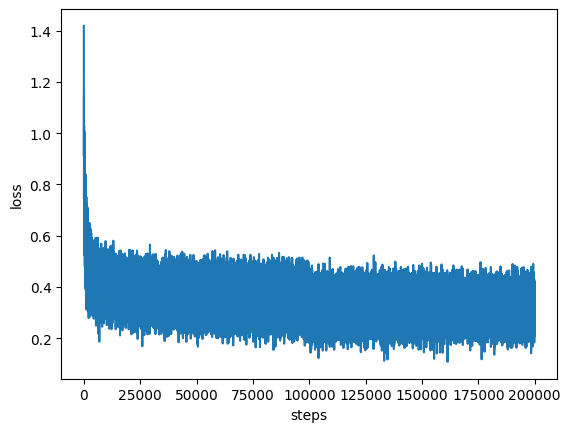

In [38]:
import matplotlib.pyplot as plt
plt.xlabel("steps")
plt.ylabel("loss")
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

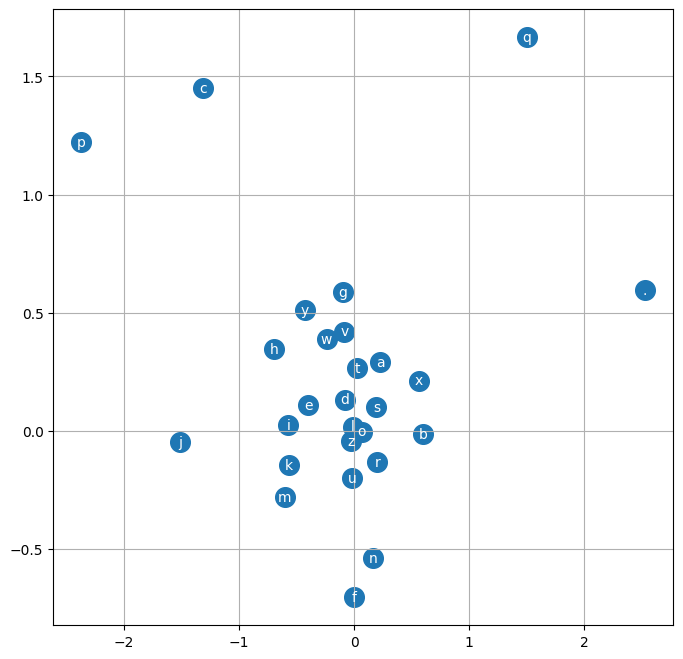

In [35]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')


In [36]:
	
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [37]:

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size 
    while True:
      emb = C[torch.tensor([context])] 
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carpaxxamille.
khi.
mili.
taty.
skaan.
kenlynnen.
delyah.
jareei.
ner.
kea.
chaiiy.
kaleigh.
ham.
join.
quintis.
lilea.
jamiques.
troxietrixi.
jaxeuni.
saylen.
